In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")  # Append pieye module root to sys.path

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms

from pieye.data import ClassificationDataset, get_filepaths, one_hot_encode_azureml_data_labels
from pieye.models import BagDetectionMobileNetV3
from pieye.labels import bag_detection_labels as classes

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [35]:
model = BagDetectionMobileNetV3(classes=classes)

model initialized:
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1)

### Load Data

In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(250),
        transforms.RandomRotation(30),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=3),  # TODO: maybe remove this
        transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': model.preprocess,
}

In [38]:
filenames, labels = one_hot_encode_azureml_data_labels(
    "../../data/labeledDatapoints.csv",
    classes=classes,
)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    filenames, labels, test_size=0.3, random_state=42,
)

In [40]:
train_dataset = ClassificationDataset(
    images_dir="../../data/images",
    image_filepaths=X_train,
    labels=y_train,
    transforms=data_transforms["train"],
)
len(train_dataset)

273

In [41]:
val_dataset = ClassificationDataset(
    images_dir="../../data/images",
    image_filepaths=X_val,
    labels=y_val,
    transforms=data_transforms["val"],
)
len(val_dataset)

118

In [42]:
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8),
    "val": DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8),
}

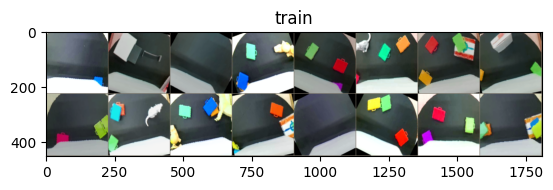

['empty', 'damaged_bag', 'empty', 'bag,stacked_bag,others', 'bag', 'bag,others', 'bag,stacked_bag', 'bag', 'bag,damaged_bag', 'bag,stacked_bag,others', 'bag,stacked_bag,others', 'bag,stacked_bag', 'empty', 'bag', 'bag', 'stacked_bag']


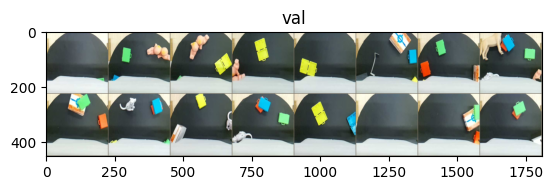

['empty', 'bag,others', 'damaged_bag,others', 'damaged_bag,others', 'damaged_bag', 'bag,damaged_bag', 'bag', 'bag,stacked_bag,others', 'bag,stacked_bag', 'stacked_bag,others', 'bag,others', 'others', 'damaged_bag', 'empty', 'stacked_bag', 'stacked_bag']


In [52]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def one_hot_encode_to_label(one_hot_encode, classes):
    return [classes[i] for i, val in enumerate(one_hot_encode) if val == 1]

for phase in ["train", "val"]:
    images, labels = next(iter(dataloaders[phase]))

    # Make a grid from batch
    out = torchvision.utils.make_grid(images)

    imshow(out, title=phase)        
    print([",".join(one_hot_encode_to_label(ohe, classes)) for ohe in labels])

### Train

Train the last layer first and then fine-tune the whole network so that the large loss from the newly added last layer doesn't affect the whole network much.

In [55]:
num_epochs = 5

# BCEWithLogitsLoss for Multi-label classification.
# It combines a Sigmoid layer and the BCELoss in one single class.
criterion = nn.BCEWithLogitsLoss()  
# Note that we are only training the head.
optimizer = torch.optim.SGD(
    model.get_last_layer_parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0005,
)

model.train(
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
)    

Number of samples: {'train': 273, 'val': 118}
Epoch 0/4 ==========
[train phase]
train F1 score: [0.1961, 0.7211, 0.24, 0.2207, 0.2154]
train Loss: 0.6605 (Weighted f1: 0.4592)
[val phase]
val F1 score: [0.0, 0.7229, 0.0667, 0.0, 0.1875]
val Loss: 0.6065 (Weighted f1: 0.3372)
Best model saved.
Epoch 1/4 ==========
[train phase]
train F1 score: [0.4615, 0.8395, 0.0, 0.0308, 0.1639]
train Loss: 0.5446 (Weighted f1: 0.4660)
[val phase]
val F1 score: [0.0, 0.7, 0.0, 0.0, 0.1935]
val Loss: 0.5372 (Weighted f1: 0.3195)
Epoch 2/4 ==========
[train phase]
train F1 score: [0.1875, 0.8441, 0.0, 0.0, 0.0702]
train Loss: 0.4713 (Weighted f1: 0.4278)
[val phase]
val F1 score: [0.0, 0.7, 0.0, 0.0, 0.1935]
val Loss: 0.5024 (Weighted f1: 0.3195)
Epoch 3/4 ==========
[train phase]
train F1 score: [0.3429, 0.8502, 0.0, 0.0, 0.3824]
train Loss: 0.4308 (Weighted f1: 0.4891)
[val phase]
val F1 score: [0.0, 0.7241, 0.0, 0.0, 0.303]
val Loss: 0.4772 (Weighted f1: 0.3491)
Best model saved.
Epoch 4/4 =========

In [56]:
num_epochs = 50

optimizer = torch.optim.SGD(
    model.get_parameters(),
    lr=0.002,
    momentum=0.9,
    weight_decay=0.0005,
)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model.train(
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs,
)    

Number of samples: {'train': 273, 'val': 118}
Epoch 0/49 ==========
[train phase]


train F1 score: [0.3429, 0.8536, 0.0, 0.0, 0.5333]
train Loss: 0.3939 (Weighted f1: 0.5131)
[val phase]
val F1 score: [0.0, 0.7683, 0.087, 0.0, 0.4444]
val Loss: 0.4468 (Weighted f1: 0.4049)
Best model saved.
Epoch 1/49 ==========
[train phase]
train F1 score: [0.6512, 0.8507, 0.0, 0.0, 0.6076]
train Loss: 0.3760 (Weighted f1: 0.5469)
[val phase]
val F1 score: [0.1739, 0.773, 0.087, 0.0, 0.4444]
val Loss: 0.4301 (Weighted f1: 0.4304)
Best model saved.
Epoch 2/49 ==========
[train phase]
train F1 score: [0.7111, 0.8488, 0.0, 0.0317, 0.7273]
train Loss: 0.3675 (Weighted f1: 0.5737)
[val phase]
val F1 score: [0.0909, 0.773, 0.087, 0.0, 0.4444]
val Loss: 0.4043 (Weighted f1: 0.4191)
Epoch 3/49 ==========
[train phase]
train F1 score: [0.6047, 0.8593, 0.0408, 0.0625, 0.7778]
train Loss: 0.3468 (Weighted f1: 0.5883)
[val phase]
val F1 score: [0.0, 0.7283, 0.1667, 0.0, 0.6]
val Loss: 0.4049 (Weighted f1: 0.4281)
Epoch 4/49 ==========
[train phase]
train F1 score: [0.6667, 0.8969, 0.1538, 0.12

In [ ]:
# Best weighted f1: {'train': 0.7473, 'val': 0.7658}

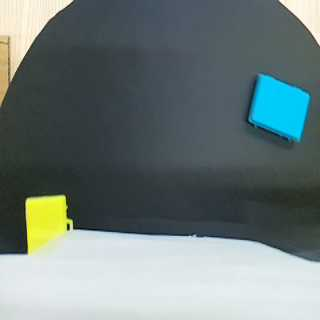

In [57]:
from PIL import Image
image = Image.open("../../data/images/vid-20240918173852713-3d8466f3-d74e-4581-b0ad-eaf78f343fa3.jpg")
image

In [58]:
pred = model.predict(image)
pred

array([[0.04166316, 0.76831216, 0.1425581 , 0.17461735, 0.05131112]],
      dtype=float32)

In [59]:
np.array(classes)[pred[0] > 0.5]

array(['bag'], dtype='<U11')

In [60]:
model.save("../../models/bag_detection_v2.pth")